In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg as lg
import exact_diagonalization as ed
import utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import h5py

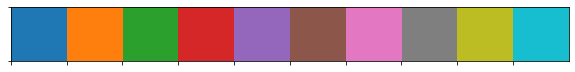

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

ed_dir = "C:/DATA/ClockV2/ed"
cp = sns.color_palette()
sns.palplot(cp)
plt.show()

In [7]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
time_steps = 20
t_final = 1.0
penalty = 10.0

t = np.linspace(0.0, t_final, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites=n_sites, h=h_ev)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

eigvals, eigvecs = np.linalg.eigh(clock_pen)
states = eigvecs.T.reshape((len(eigvecs),) + exact_state.shape)
ground_state = states[0]

In [15]:
clock_energy = lambda x: (x.ravel().conj() * clock_pen.dot(x.ravel())).sum() / np.sqrt((np.abs(x)**2).sum())
print(eigvals[:10])

[0.00180443 0.00581409 0.00581591 0.00581591 0.00581591 0.00581591
 0.00581953 0.00582218 0.00582218 0.00582617]


In [19]:
constr_state = [np.copy(exact_state[0])]
u_constr = np.eye(2**n_sites) - 1j * dt * ham
for i in range(time_steps):
    constr_state.append(u_constr.dot(constr_state[-1]))
constr_state = np.array(constr_state)
print(constr_state.shape)

(21, 64)


In [20]:
print("Ground state: {}".format(clock_energy(ground_state)))
print("Exact evolution: {}".format(clock_energy(exact_state)))
print("Construction: {}".format(clock_energy(constr_state)))

Ground state: (0.001804434062507924-2.42314133962141e-17j)
Exact evolution: (0.00920064001990329+6.056763153128083e-17j)
Construction: (0.03204212171757775-2.710589641365718e-16j)


In [6]:
n_sites = 6
init_state = np.ones(2**n_sites) / np.sqrt(2**n_sites)
h_ev = 0.5
time_steps = 20
t_final = 1.0
penalty = 100.0

t = np.linspace(0.0, t_final, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, init_state=init_state, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites=n_sites, h=h_ev)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

eigvals, eigvecs = np.linalg.eigh(clock_pen)
states = eigvecs.T.reshape((len(eigvecs),) + exact_state.shape)

In [7]:
eigvals[:10]

array([0.00047982, 0.00586518, 0.00586703, 0.00586703, 0.00586703,
       0.00586703, 0.00587338, 0.00587338, 0.00587742, 0.00587742])

Diagonalize and save energies and overlaps to use in the `plotter.py` to plot energy levels and compare with sampling plateus

In [4]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
time_steps = 20
penalty = 10.0

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites=n_sites, h=h_ev)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

eigvals, eigvecs = np.linalg.eigh(clock_pen)
states = eigvecs.T.reshape((len(eigvecs),) + exact_state.shape)

file = h5py.File("ed_results_N{}M{}.h5".format(n_sites, time_steps), "w")
file["overlaps"] = np.array([utils.overlap(exact_state, s) for s in states])
file["avg_overlaps"] = np.array([utils.averaged_overlap(exact_state, s) for s in states])
file["energies"] = eigvals
file.close()

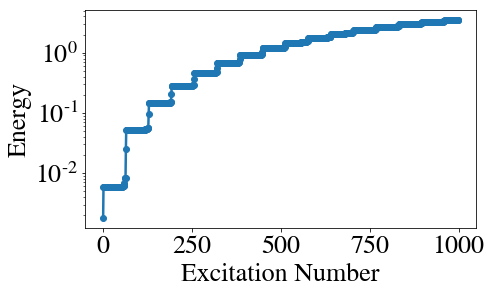

In [50]:
ed = h5py.File("{}/ed_results_N{}M{}.h5".format(ed_dir, n_sites, time_steps), "r")

#energy_diff = ed["energies"][1:] - ed["energies"][:-1]

plt.figure(figsize=(7, 4))
plt.semilogy(ed["energies"][:1000], "-o", linewidth=2.5)
plt.xlabel("Excitation Number")
plt.ylabel("Energy")
plt.show()

ed.close()

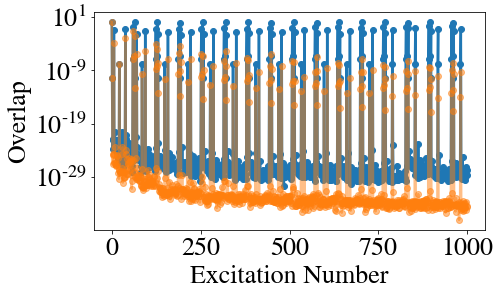

In [52]:
ed = h5py.File("{}/ed_results_N{}M{}.h5".format(ed_dir, n_sites, time_steps), "r")

#energy_diff = ed["energies"][1:] - ed["energies"][:-1]

plt.figure(figsize=(7, 4))
plt.semilogy(ed["avg_overlaps"][:1000], "-o", linewidth=2.5, color=cp[0])
plt.semilogy(ed["overlaps"][:1000], "-o", linewidth=2.5, color=cp[1], alpha=0.5)
plt.xlabel("Excitation Number")
plt.ylabel("Overlap")
plt.show()

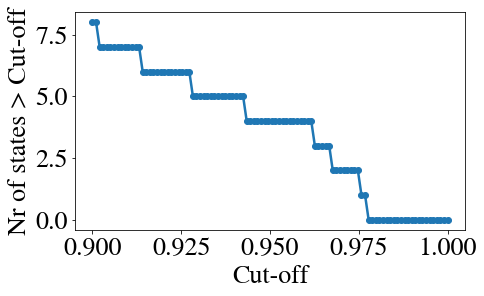

In [76]:
ov_cut_offs = np.linspace(0.9, 1.0, 100)
better_overlap = np.array([(ed["avg_overlaps"] > c).sum() for c in ov_cut_offs])

plt.figure(figsize=(7, 4))
plt.plot(ov_cut_offs, better_overlap, "-o", linewidth=2.5, color=cp[0])
plt.xlabel("Cut-off")
plt.ylabel("Nr of states > Cut-off")
plt.show()

In [79]:
ed["energies"][ed["avg_overlaps"][()] > 0.95]

array([0.00180443, 0.09449441, 0.36433887, 0.78755567])

In [92]:
np.where(ed["avg_overlaps"][()] > 0.95)[0]

array([  0, 128, 256, 384], dtype=int64)

Calculate overlaps between solving the Clock system and exact evolution for various $T$s

In [17]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

T_list = np.arange(20, 220, 20)
t_final_list = [1.0, 1.5, 2.0]

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

overlaps = []
for t_final in t_final_list:
    overlaps.append({"full": [], "averaged": []})
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
        clock = ed.construct_sparse_clock(ham, dt, time_steps)
        
        system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
        overlaps[-1]["full"].append(utils.overlap(exact_state, system_state))
        overlaps[-1]["averaged"].append(utils.averaged_overlap(exact_state, system_state))
        print(".", end="")

    for k in overlaps[-1].keys():
        overlaps[-1][k] = np.array(overlaps[-1][k])
    print()

..........
..........
..........


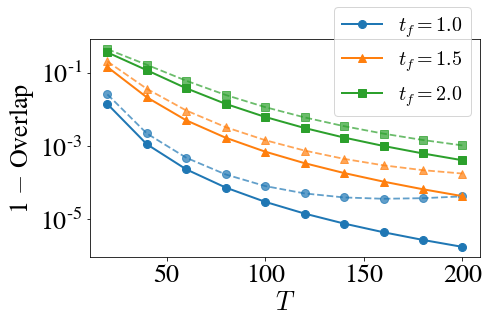

In [18]:
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, 1 - overlaps[i]["averaged"], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
    plt.semilogy(T_list, 1 - overlaps[i]["full"], "--", marker=markers[i], linewidth=1.8, markersize=8, color=cp[i], alpha=0.7)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend(loc="lower left", bbox_to_anchor=(0.6, 0.6), fontsize=20)
#plt.show()
plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

Calculate observables by solving the system

In [10]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
pauli = utils.Pauli(ham.dtype)

t_final = 3.0
exact_x = []
system_x = []
T_list = [50, 100, 150, 200]
for time_steps in T_list:
    t = np.linspace(0.0, t_final, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    exact_x.append(obs["X"])

    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    system_state *= 1.0 / np.sqrt((np.abs(system_state)**2).sum(axis=1))[:, np.newaxis]
    system_x.append(utils.ev_local(system_state, pauli.X))
    print(".", end="")

....

C:\Users\SU\AppData\Roaming\Python\Python37\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


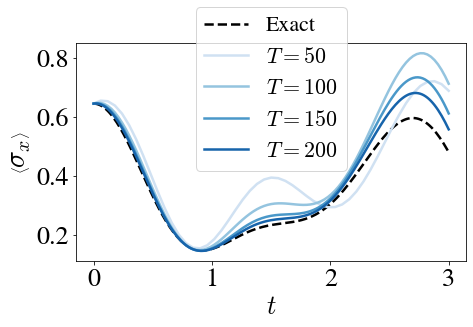

In [16]:
cseq = sns.color_palette("Blues", len(system_x))
plt.figure(figsize=(7, 4))
plt.plot(t, exact_x[-1], "--", color="black", linewidth=2.5, label="Exact")
for i, time_steps in enumerate(T_list):
     plt.plot(np.linspace(0.0, t_final, time_steps + 1), system_x[i], 
              linewidth=2.5, color=cseq[i], label="$T={}$".format(time_steps))
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$", fontsize=28)
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.79), fontsize=22)
#plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05), fontsize=22)
#plt.show()
plt.savefig("sigma_x_system.pdf", bbox_inches='tight')

In [43]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
pauli = utils.Pauli(ham.dtype)

t_final = 3.0
exact_x = []
system_x = []
T_list = [50, 100, 150, 200]
for time_steps in T_list:
    t = np.linspace(0.0, t_final, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    exact_x.append(obs["X"])

    clock = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=10.0, psi0=exact_state[0])
    _, clock_state = scipy.linalg.eigh(np.array(clock.todense()), eigvals=(0, 0))
    clock_state = clock_state[:, 0].reshape(exact_state.shape)
    clock_state *= 1.0 / np.sqrt((np.abs(clock_state)**2).sum(axis=1))[:, np.newaxis]
    system_x.append(utils.ev_local(clock_state, pauli.X))
    print(".", end="")

....

C:\Users\SU\AppData\Roaming\Python\Python37\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


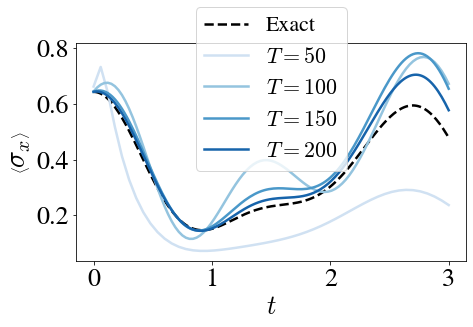

In [44]:
cseq = sns.color_palette("Blues", len(system_x))
plt.figure(figsize=(7, 4))
plt.plot(t, exact_x[-1], "--", color="black", linewidth=2.5, label="Exact")
for i, time_steps in enumerate(T_list):
     plt.plot(np.linspace(0.0, t_final, time_steps + 1), system_x[i], 
              linewidth=2.5, color=cseq[i], label="$T={}$".format(time_steps))
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$", fontsize=28)
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.79), fontsize=22)
#plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05), fontsize=22)
#plt.show()
plt.savefig("sigma_x_eig.pdf", bbox_inches='tight')

Solve eigenvalue problem for Clock with penalty term for the initial condition and check how it compares with exact evolution and the Clock system solution

In [19]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 20
penalty = 10.0

t = np.linspace(0.0, 3.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
clock = ed.construct_sparse_clock(ham, dt, time_steps)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
eigvals, eigvecs = np.linalg.eigh(clock_pen)
eig_state = eigvecs[:, 0].reshape(exact_state.shape)

print("Penalty: {}".format(penalty))
print("\nSystem - Exact: {}".format(utils.averaged_overlap(exact_state, system_state)))
print("Eig - Exact: {}".format(utils.averaged_overlap(exact_state, eig_state)))
print("System - Eig: {}".format(utils.averaged_overlap(eig_state, system_state)))

clock_ev = lambda state: state.ravel().conj().dot(clock_pen.dot(state.ravel())) / (np.abs(state)**2).sum()
print("\nClock EVs:")
print("Exact: {}".format(clock_ev(exact_state)))
print("System: {}".format(clock_ev(system_state)))
print("Eig: {}".format(clock_ev(eig_state)))

Convergence status: 0
Penalty: 10.0

System - Exact: 0.5515175297584666
Eig - Exact: 6.0902642218166844e-24
System - Eig: 6.267117672764493e-24

Clock EVs:
Exact: (0.03478907027650905+1.0573552615477664e-17j)
System: (0.034707893080177125-2.765810748728232e-18j)
Eig: (0.005811628078718459-3.903127820947815e-18j)


Check how changing the penalty coefficient affects the overlap between exact and lowest eigenstate

In [4]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 60
penalty_list = np.linspace(1e-2, 10, 30)

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

overlaps = {"full": [], "averaged": []}
for penalty in penalty_list:
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())

    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    
    overlaps["full"].append(utils.overlap(exact_state, eig_state))
    overlaps["averaged"].append(utils.averaged_overlap(exact_state, eig_state))
    print(".", end="")

for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])

..

KeyboardInterrupt: 

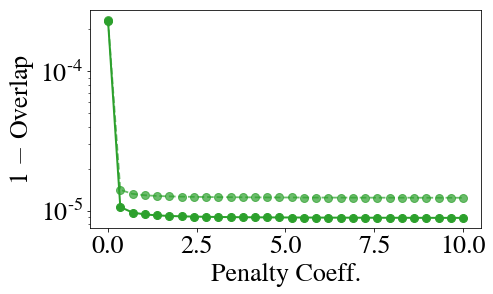

In [60]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    n = len(overlaps[k])
    
plt.figure(figsize=(7, 4))
plt.semilogy(penalty_list[:n], 1 - overlaps["averaged"], marker="o", linewidth=2.0, markersize=8, color=cp[2])
plt.semilogy(penalty_list[:n], 1 - overlaps["full"], "--", marker="o", linewidth=1.8, markersize=8, color=cp[2], alpha=0.7)
plt.xlabel("Penalty Coeff.")
plt.ylabel("1 $-$ Overlap")
plt.show()

we see that if the penalty value is large enough, then it does not affect the physics. Hence, it is okay to use a large constant penalty.

Compare solving system, solving eigenvalue with penalty and optimizing

In [3]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
data_dir = "C:/DATA/ClockV2/histories"
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

T_list = [20, 25, 30, 35]
overlaps = {"System": [], "Eig.": [], "Opt.": []}
for time_steps in T_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]

    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    overlaps["System"].append(utils.averaged_overlap(exact_state, system_state))
    
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=10.0, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())
    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    overlaps["Eig."].append(utils.averaged_overlap(exact_state, eig_state))
    
    opt_hist = h5py.File("{}/N={}/allstates_fullwv_N{}M{}.h5py".format(data_dir, n_sites, n_sites, time_steps), "r")
    overlaps["Opt."].append(opt_hist["avg_overlaps"][-1])
    opt_hist.close()
    print(".", end="")

.

KeyboardInterrupt: 

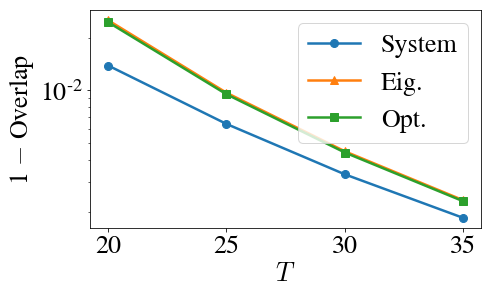

In [28]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(T_list, 1 - overlaps[k], marker=markers[i], linewidth=2.5, markersize=8, color=cp[i], label=k)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

In [8]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

T_list = [20, 25, 30, 35]
overlaps = {"System": [], "Eig.": []}
for time_steps in T_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]

    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    overlaps["System"].append(utils.averaged_overlap(exact_state, system_state))
    
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=10.0, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())
    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    overlaps["Eig."].append(utils.averaged_overlap(exact_state, eig_state))
    print(".", end="")

....

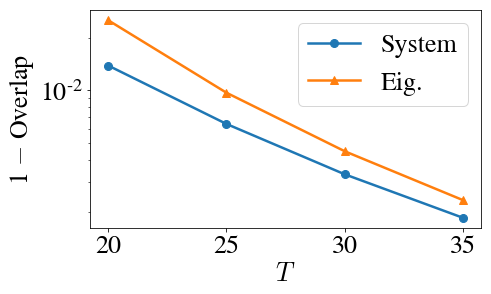

In [9]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(T_list, 1 - overlaps[k], marker=markers[i], linewidth=2.5, markersize=8, color=cp[i], label=k)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

Detailed comparison between eigenvalue problem with the penalty term and solving the system to enforce the initial condition.

In [4]:
n_sites = 6
time_steps = 20
h_init = 1.0
h_ev = 0.5
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    
clock = ed.construct_sparse_clock(ham, dt, time_steps)
system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=1e8, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())
eigvals, eigvecs = np.linalg.eigh(clock_pen)
eig_state = eigvecs[:, 0].reshape(exact_state.shape)

In [5]:
system_norms = (np.abs(system_state)**2).sum(axis=1)
eig_norms = (np.abs(eig_state)**2).sum(axis=1)

print(np.abs((exact_state[0].conj() * system_state[0]).sum())**2 / system_norms[0])
print(np.abs((exact_state[0].conj() * eig_state[0]).sum())**2 / eig_norms[0])

1.0
0.9999999999999996


In [6]:
eigvals[:5]

array([0.00180646, 0.0058709 , 0.00587275, 0.00587275, 0.00587275])

In [7]:
print(utils.averaged_overlap(state1=exact_state, state2=system_state))
print(utils.averaged_overlap(state1=exact_state, state2=eig_state))

0.9861140782513661
0.9754030434664942


In [8]:
print((eig_state.ravel().conj() * clock_pen.dot(eig_state.ravel())).sum() / eig_norms.sum())
print((system_state.ravel().conj() * clock_pen.dot(system_state.ravel())).sum() / system_norms.sum())

(0.0018064475492123578-1.2256821104808074e-18j)
(0.002211127899214073+3.074181259143122e-17j)


In [10]:
eig_overlaps = np.abs((exact_state.conj() * eig_state).sum(axis=1))**2 / (eig_norms)
system_overlaps = np.abs((exact_state.conj() * system_state).sum(axis=1))**2 / (system_norms)

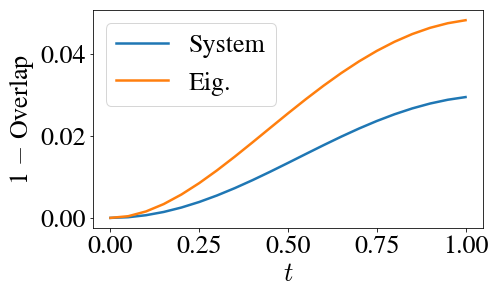

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(t, 1 - system_overlaps, color=cp[0], linewidth=2.5, label="System")
plt.plot(t, 1 - eig_overlaps, color=cp[1], linewidth=2.5, label="Eig.")
plt.xlabel("$t$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

Check how differences scale with $N$

In [42]:
n_sites_list = [3, 4, 5, 6]
h_init = 1.0
h_ev = 0.5
time_steps = 20
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

overlaps = {"System": [], "Eig.": []}
norms = {"System": [], "Eig.": []}
norms_check = []
energies = {"System": [], "Eig.": []}
for n_sites in n_sites_list:
    ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=10.0, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())
    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    
    norms_check.append(eigvals[0])
    for k, state in zip(["System", "Eig."], [system_state, eig_state]):
        overlaps[k].append(utils.averaged_overlap(exact_state, state))
        norms[k].append((np.abs(state)**2).sum(axis=1))
        energies[k].append((state.ravel().conj() * clock_pen.dot(state.ravel())).sum() / norms[k][-1].sum())

    print(".", end="")

....

In [44]:
make_arrays = lambda x: {k: np.array(x[k]) for k in x.keys()}

overlaps = make_arrays(overlaps)
norms = make_arrays(norms)
energies = make_arrays(energies)
norms_check = np.array(norms_check)

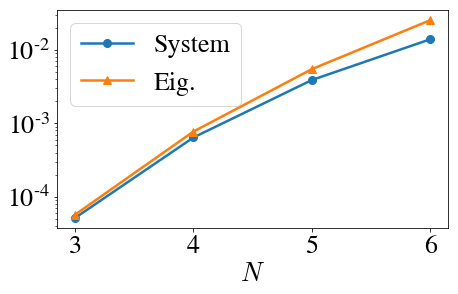

In [48]:
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(n_sites_list, 1 - overlaps[k], marker=markers[i], linewidth=2.5, markersize=8, color=cp[i], label=k)
plt.xlabel("$N$")
#plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

Check how changing the RHS energy in the system affects solution

In [13]:
n_sites = 6
time_steps = 20
h_init = 1.0
h_ev = 0.5
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=1e8, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())
eigvals, eigvecs = np.linalg.eigh(clock_pen)
eig_state = eigvecs[:, 0].reshape(exact_state.shape)

In [20]:
eigvals[:5]

array([0.00180646, 0.0058709 , 0.00587275, 0.00587275, 0.00587275])

In [49]:
en_system = np.linspace(-6e-3, 6e-3, 50)
calculate_clock_energy = lambda state: (state.ravel().conj() * clock_pen.dot(state.ravel())).sum() / (np.abs(state)**2).sum()

eig = {"avg_overlap": utils.averaged_overlap(exact_state, eig_state),
       "overlap": utils.overlap(exact_state, eig_state),
       "energy": calculate_clock_energy(eig_state)}

system = {"avg_overlap": [], "overlap": [], "energy": []}
for en in en_system:
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    clock = clock - en * sparse.eye(clock.shape[0], dtype=clock.dtype)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    system["avg_overlap"].append(utils.averaged_overlap(exact_state, system_state))
    system["overlap"].append(utils.overlap(exact_state, system_state))
    system["energy"].append(calculate_clock_energy(system_state))
    
system = {k: np.array(system[k]) for k in system.keys()}

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


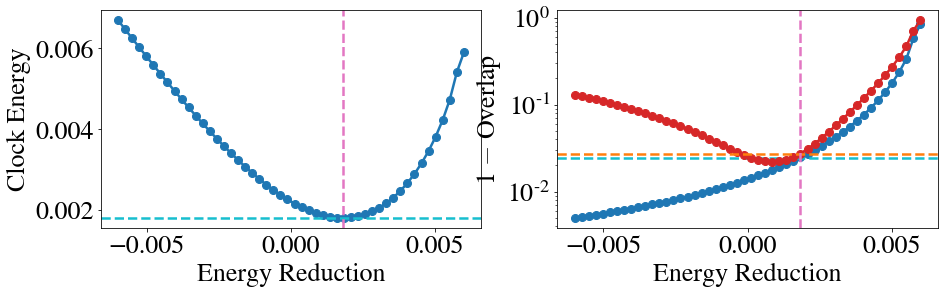

In [50]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(en_system, system["energy"], color=cp[0], marker="o", markersize=8, linewidth=2.5)
plt.axhline(y=eig["energy"], color=cp[-1], linestyle="--", linewidth=2.5)
plt.axvline(x=eigvals[0], color=cp[6], linestyle="--", linewidth=2.5)
plt.xlabel("Energy Reduction")
plt.ylabel("Clock Energy")

plt.subplot(122)
plt.semilogy(en_system, 1 - system["avg_overlap"], color=cp[0], marker="o", markersize=8, linewidth=2.5)
plt.axhline(y=1 - eig["avg_overlap"], color=cp[-1], linestyle="--", linewidth=2.5)
plt.semilogy(en_system, 1 - system["overlap"], color=cp[3], marker="o", markersize=8, linewidth=2.5)
plt.axhline(y=1 - eig["overlap"], color=cp[1], linestyle="--", linewidth=2.5)
plt.axvline(x=eigvals[0], color=cp[6], linestyle="--", linewidth=2.5)
plt.xlabel("Energy Reduction")
plt.ylabel("1 $-$ Overlap")


plt.show()

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


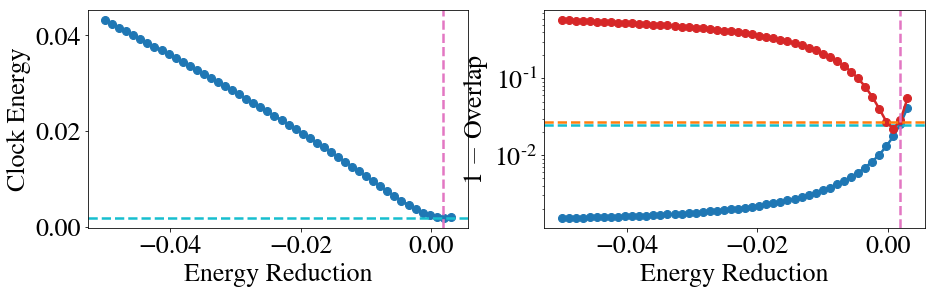

In [54]:
en_system = np.linspace(-0.05, 3e-3, 50)
calculate_clock_energy = lambda state: (state.ravel().conj() * clock_pen.dot(state.ravel())).sum() / (np.abs(state)**2).sum()

eig = {"avg_overlap": utils.averaged_overlap(exact_state, eig_state),
       "overlap": utils.overlap(exact_state, eig_state),
       "energy": calculate_clock_energy(eig_state)}

system = {"avg_overlap": [], "overlap": [], "energy": []}
for en in en_system:
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    clock = clock - en * sparse.eye(clock.shape[0], dtype=clock.dtype)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    system["avg_overlap"].append(utils.averaged_overlap(exact_state, system_state))
    system["overlap"].append(utils.overlap(exact_state, system_state))
    system["energy"].append(calculate_clock_energy(system_state))
    
system = {k: np.array(system[k]) for k in system.keys()}

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(en_system, system["energy"], color=cp[0], marker="o", markersize=8, linewidth=2.5)
plt.axhline(y=eig["energy"], color=cp[-1], linestyle="--", linewidth=2.5)
plt.axvline(x=eigvals[0], color=cp[6], linestyle="--", linewidth=2.5)
plt.xlabel("Energy Reduction")
plt.ylabel("Clock Energy")

plt.subplot(122)
plt.semilogy(en_system, 1 - system["avg_overlap"], color=cp[0], marker="o", markersize=8, linewidth=2.5)
plt.axhline(y=1 - eig["avg_overlap"], color=cp[-1], linestyle="--", linewidth=2.5)
plt.semilogy(en_system, 1 - system["overlap"], color=cp[3], marker="o", markersize=8, linewidth=2.5)
plt.axhline(y=1 - eig["overlap"], color=cp[1], linestyle="--", linewidth=2.5)
plt.axvline(x=eigvals[0], color=cp[6], linestyle="--", linewidth=2.5)
plt.xlabel("Energy Reduction")
plt.ylabel("1 $-$ Overlap")


plt.show()

Check how the gap changes as a function of $T$ and $t$ for constant penalty. Notice that there is a **critical** $dt$ after which the system becomes "gapless" and solving the system or diagonalizing the Clock Hamiltonian does not give the correct evolution (we can check that by calculating the corresponding overlaps above).

In [37]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(1, 20)
penalty = 1000.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()

...................
...................
...................
...................
...................
...................


For $N=4$ spins

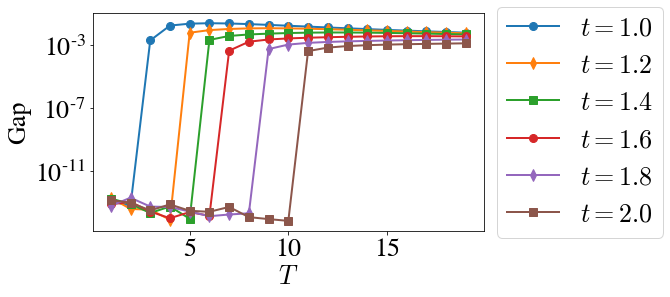

In [38]:
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

For $N=6$ spins

...................
...................
...................
...................
...................
...................


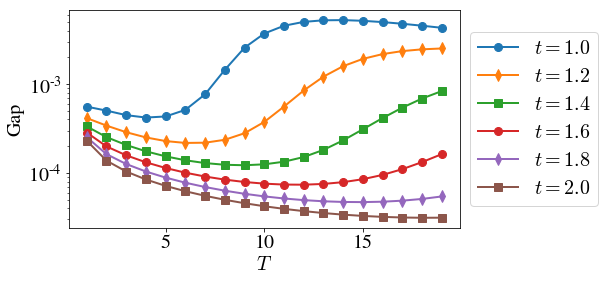

In [12]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(1, 20)
penalty = 1000.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

For $N=6$ spins

.....
.....
.....
.....
.....
.....


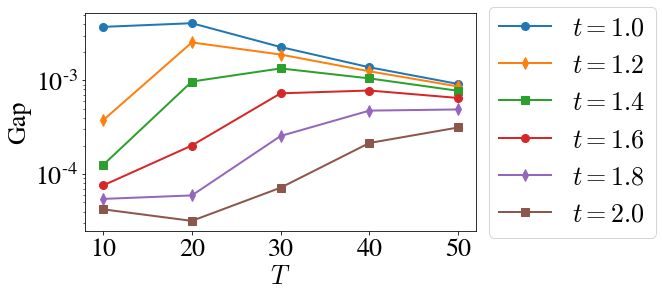

In [8]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(10, 51, 10)
penalty = 1000.0
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [44]:
n_sites = 4
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
time_steps = 20
t = np.linspace(0.0, 1.0, 21)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

clock_pen = ed.construct_sparse_clock(ham, dt, 20, init_penalty=100.0, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

eigvals, eigstates = np.linalg.eigh(clock_pen)
eigvals[:10]

ground = eigstates[:, 0].reshape(exact_state.shape)
ground *= 1.0 / np.sqrt((np.abs(ground)**2).sum(axis=1)[:, np.newaxis])

excited = eigstates[:, 1].reshape(exact_state.shape)
excited *= 1.0 / np.sqrt((np.abs(excited)**2).sum(axis=1)[:, np.newaxis])

In [45]:
print(utils.averaged_overlap(ground, exact_state))
print(utils.averaged_overlap(excited, exact_state))

0.999241683539311
1.0757720148179126e-20


1.0757720148179126e-20

Repeat the same plot but for proper $dt$s so that the method works well

..........
..........
..........
..........
..........


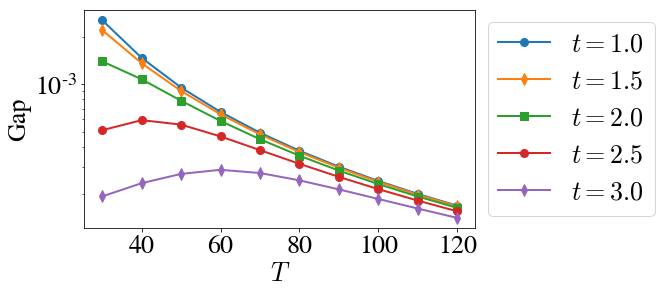

In [40]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.5, 2.0, 2.5, 3.0]
T_list = np.arange(30, 130, 10)
penalty = 10.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.5, 2.0, 2.5, 3.0]
T_list = np.arange(30, 110, 10)
penalty = 10.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

..

KeyboardInterrupt: 

..............................

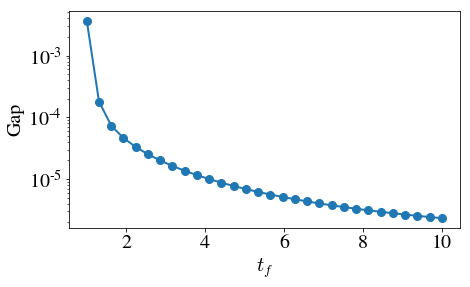

In [11]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
penalty = 100.0
time_steps = 10
t_final_list = np.linspace(1.0, 10.0, 30)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

gaps = []
for t_final in t_final_list:
    t = np.linspace(0.0, t_final, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())

    eigvals = np.linalg.eigvalsh(clock_pen)
    gaps.append(eigvals[1] - eigvals[0])

    print(".", end="")
    
plt.figure(figsize=(7, 4))
plt.semilogy(t_final_list, gaps, marker="o", linewidth=2.0, markersize=8, color=cp[0])
plt.xlabel("$t_f$")
plt.ylabel("Gap")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()